In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 1024 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_1024____2020_08_09_22_14_06_923244_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

In [13]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [14]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [15]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [16]:
history = model.fit(
    X_labeled,
    Y_labeled_one_hot,
    batch_size=batch_size,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/500
 2/80 [..............................] - ETA: 4s - loss: 2.5432 - accuracy: 0.1016

W0809 22:14:26.306612 140352205076288 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0233s vs `on_train_batch_end` time: 0.0917s). Check your callbacks.


80/80 [==============================] - 15s 191ms/step - loss: 2.0926 - accuracy: 0.2959 - val_loss: 2.7017 - val_accuracy: 0.2578
Epoch 2/500
80/80 [==============================] - 14s 172ms/step - loss: 1.9045 - accuracy: 0.4059 - val_loss: 2.4318 - val_accuracy: 0.3042
Epoch 3/500
80/80 [==============================] - 16s 201ms/step - loss: 1.8280 - accuracy: 0.4505 - val_loss: 3.3582 - val_accuracy: 0.2559
Epoch 4/500
80/80 [==============================] - 17s 208ms/step - loss: 1.7660 - accuracy: 0.4905 - val_loss: 2.3711 - val_accuracy: 0.3444
Epoch 5/500
80/80 [==============================] - 17s 211ms/step - loss: 1.7145 - accuracy: 0.5238 - val_loss: 2.6766 - val_accuracy: 0.2805
Epoch 6/500
80/80 [==============================] - 17s 212ms/step - loss: 1.6852 - accuracy: 0.5409 - val_loss: 2.6663 - val_accuracy: 0.3032
Epoch 7/500
80/80 [==============================] - 16s 205ms/step - loss: 1.6446 - accuracy: 0.5688 - val_loss: 2.6102 - val_accuracy: 0.2738
Epoc

80/80 [==============================] - 17s 218ms/step - loss: 1.0160 - accuracy: 0.9572 - val_loss: 1.4973 - val_accuracy: 0.6987
Epoch 58/500
80/80 [==============================] - 17s 213ms/step - loss: 1.0081 - accuracy: 0.9636 - val_loss: 1.5436 - val_accuracy: 0.6858
Epoch 59/500
80/80 [==============================] - 17s 214ms/step - loss: 1.0095 - accuracy: 0.9626 - val_loss: 1.6183 - val_accuracy: 0.6553
Epoch 60/500
80/80 [==============================] - 17s 208ms/step - loss: 1.0019 - accuracy: 0.9685 - val_loss: 1.4898 - val_accuracy: 0.7084
Epoch 61/500
80/80 [==============================] - 17s 211ms/step - loss: 0.9940 - accuracy: 0.9700 - val_loss: 1.5067 - val_accuracy: 0.6995
Epoch 62/500
80/80 [==============================] - 17s 212ms/step - loss: 1.0000 - accuracy: 0.9679 - val_loss: 1.4854 - val_accuracy: 0.7108
Epoch 63/500
80/80 [==============================] - 17s 207ms/step - loss: 0.9942 - accuracy: 0.9714 - val_loss: 1.4833 - val_accuracy: 0.706

80/80 [==============================] - 13s 165ms/step - loss: 0.9172 - accuracy: 0.9937 - val_loss: 1.3863 - val_accuracy: 0.7501
Epoch 114/500
80/80 [==============================] - 13s 165ms/step - loss: 0.9156 - accuracy: 0.9945 - val_loss: 1.3316 - val_accuracy: 0.7703
Epoch 115/500
80/80 [==============================] - 13s 165ms/step - loss: 0.9138 - accuracy: 0.9934 - val_loss: 1.4339 - val_accuracy: 0.7258
Epoch 116/500
80/80 [==============================] - 14s 179ms/step - loss: 0.9120 - accuracy: 0.9951 - val_loss: 1.3870 - val_accuracy: 0.7443
Epoch 117/500
80/80 [==============================] - 14s 171ms/step - loss: 0.9088 - accuracy: 0.9963 - val_loss: 1.3480 - val_accuracy: 0.7631
Epoch 118/500
80/80 [==============================] - 14s 179ms/step - loss: 0.9098 - accuracy: 0.9955 - val_loss: 1.3520 - val_accuracy: 0.7600
Epoch 119/500
80/80 [==============================] - 13s 162ms/step - loss: 0.9070 - accuracy: 0.9959 - val_loss: 1.3774 - val_accuracy:

80/80 [==============================] - 12s 145ms/step - loss: 0.8862 - accuracy: 0.9978 - val_loss: 1.3000 - val_accuracy: 0.7856
Epoch 170/500
80/80 [==============================] - 12s 146ms/step - loss: 0.8886 - accuracy: 0.9961 - val_loss: 1.3267 - val_accuracy: 0.7749
Epoch 171/500
80/80 [==============================] - 11s 135ms/step - loss: 0.8913 - accuracy: 0.9952 - val_loss: 1.3049 - val_accuracy: 0.7827
Epoch 172/500
80/80 [==============================] - 12s 148ms/step - loss: 0.8900 - accuracy: 0.9960 - val_loss: 1.3530 - val_accuracy: 0.7644
Epoch 173/500
80/80 [==============================] - 13s 169ms/step - loss: 0.8881 - accuracy: 0.9961 - val_loss: 1.3078 - val_accuracy: 0.7825
Epoch 174/500
80/80 [==============================] - 10s 119ms/step - loss: 0.8884 - accuracy: 0.9966 - val_loss: 1.3208 - val_accuracy: 0.7815
Epoch 175/500
80/80 [==============================] - 10s 122ms/step - loss: 0.8857 - accuracy: 0.9974 - val_loss: 1.3168 - val_accuracy:

80/80 [==============================] - 9s 118ms/step - loss: 0.8836 - accuracy: 0.9953 - val_loss: 1.3144 - val_accuracy: 0.7846
Epoch 226/500
80/80 [==============================] - 10s 124ms/step - loss: 0.8843 - accuracy: 0.9952 - val_loss: 1.3672 - val_accuracy: 0.7659
Epoch 227/500
80/80 [==============================] - 10s 122ms/step - loss: 0.8816 - accuracy: 0.9960 - val_loss: 1.3293 - val_accuracy: 0.7802
Epoch 228/500
80/80 [==============================] - 9s 118ms/step - loss: 0.8810 - accuracy: 0.9965 - val_loss: 1.3073 - val_accuracy: 0.7921
Epoch 229/500
80/80 [==============================] - 10s 124ms/step - loss: 0.8808 - accuracy: 0.9963 - val_loss: 1.3136 - val_accuracy: 0.7894
Epoch 230/500
80/80 [==============================] - 10s 123ms/step - loss: 0.8787 - accuracy: 0.9973 - val_loss: 1.3222 - val_accuracy: 0.7857
Epoch 231/500
80/80 [==============================] - 9s 118ms/step - loss: 0.8837 - accuracy: 0.9947 - val_loss: 1.3540 - val_accuracy: 0.

80/80 [==============================] - 10s 124ms/step - loss: 0.8792 - accuracy: 0.9961 - val_loss: 1.3297 - val_accuracy: 0.7830
Epoch 282/500
80/80 [==============================] - 10s 122ms/step - loss: 0.8760 - accuracy: 0.9981 - val_loss: 1.3213 - val_accuracy: 0.7899
Epoch 283/500
80/80 [==============================] - 10s 119ms/step - loss: 0.8749 - accuracy: 0.9975 - val_loss: 1.3034 - val_accuracy: 0.7980
Epoch 284/500
80/80 [==============================] - 10s 124ms/step - loss: 0.8763 - accuracy: 0.9971 - val_loss: 1.3482 - val_accuracy: 0.7782
Epoch 285/500
80/80 [==============================] - 10s 120ms/step - loss: 0.8775 - accuracy: 0.9966 - val_loss: 1.3772 - val_accuracy: 0.7678
Epoch 286/500
80/80 [==============================] - 10s 119ms/step - loss: 0.8778 - accuracy: 0.9963 - val_loss: 1.2923 - val_accuracy: 0.8044
Epoch 287/500
80/80 [==============================] - 10s 123ms/step - loss: 0.8768 - accuracy: 0.9972 - val_loss: 1.3216 - val_accuracy:

80/80 [==============================] - 9s 118ms/step - loss: 0.8763 - accuracy: 0.9970 - val_loss: 1.3320 - val_accuracy: 0.7895
Epoch 338/500
80/80 [==============================] - 10s 123ms/step - loss: 0.8776 - accuracy: 0.9963 - val_loss: 1.3446 - val_accuracy: 0.7823
Epoch 339/500
80/80 [==============================] - 10s 122ms/step - loss: 0.8722 - accuracy: 0.9993 - val_loss: 1.2941 - val_accuracy: 0.8029
Epoch 340/500
80/80 [==============================] - 9s 119ms/step - loss: 0.8727 - accuracy: 0.9981 - val_loss: 1.3121 - val_accuracy: 0.7945
Epoch 341/500
80/80 [==============================] - 10s 123ms/step - loss: 0.8731 - accuracy: 0.9980 - val_loss: 1.2979 - val_accuracy: 0.8029
Epoch 342/500
80/80 [==============================] - 10s 124ms/step - loss: 0.8748 - accuracy: 0.9967 - val_loss: 1.3566 - val_accuracy: 0.7778
Epoch 343/500
80/80 [==============================] - 9s 117ms/step - loss: 0.8744 - accuracy: 0.9971 - val_loss: 1.2993 - val_accuracy: 0.

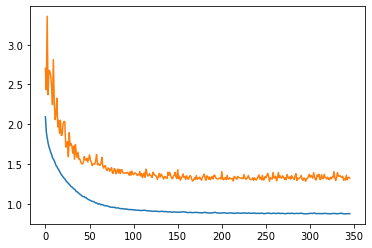

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

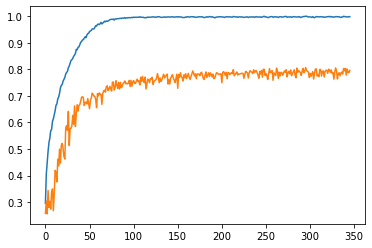

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [19]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [20]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 23:29:45 2020 Finding Nearest Neighbors
Sun Aug  9 23:29:45 2020 Building RP forest with 15 trees
Sun Aug  9 23:29:46 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Sun Aug  9 23:29:56 2020 Finished Nearest Neighbor Search
Sun Aug  9 23:29:59 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 23:30:39 2020 Finished embedding


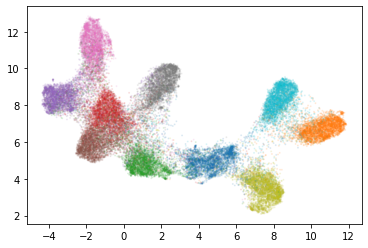

In [21]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 23:30:45 2020 Finding Nearest Neighbors
Sun Aug  9 23:30:45 2020 Building RP forest with 10 trees
Sun Aug  9 23:30:45 2020 parallel NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
Sun Aug  9 23:30:46 2020 Finished Nearest Neighbor Search
Sun Aug  9 23:30:46 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Aug  9 23:31:03 2020 Finished embedding


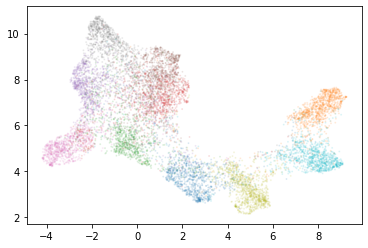

In [22]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

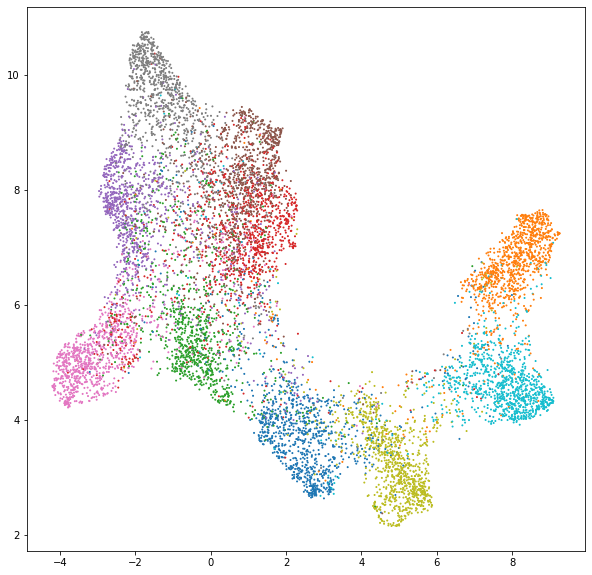

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [24]:
predictions = model.predict(X_valid)

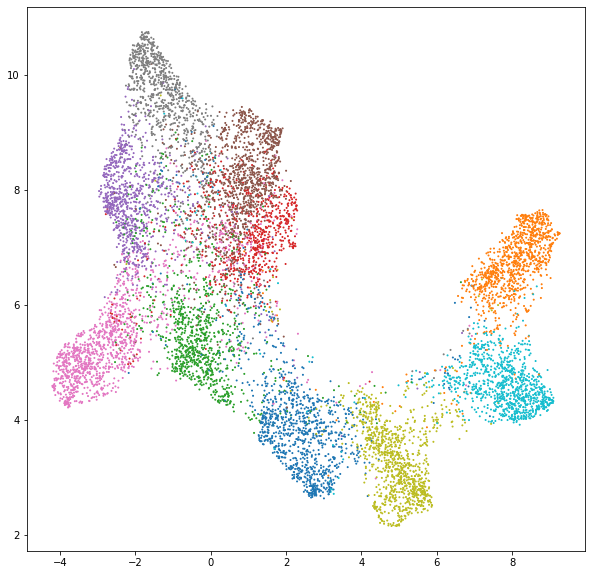

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)

### save results

In [26]:
# save score, valid embedding, weights, results

In [27]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [28]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [29]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [30]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [31]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [32]:
classifier.save_weights((save_folder / "classifier").as_posix())

In [41]:
model.save_weights((save_folder / "full_model").as_posix())

#### save score

In [33]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 9ms/step - loss: 1.3365 - accuracy: 0.7864


In [34]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [36]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Aug 10 09:28:41 2020 Finding Nearest Neighbors
Mon Aug 10 09:28:42 2020 Building RP forest with 15 trees
Mon Aug 10 09:28:42 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Mon Aug 10 09:28:44 2020 Finished Nearest Neighbor Search
Mon Aug 10 09:28:45 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Aug 10 09:29:45 2020 Finished embedding


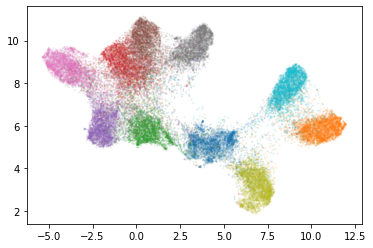

In [37]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [38]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [39]:
import pickle

In [40]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)